#Ecuadorian Network
Evaluation of data from Pypsa-Earth


In [110]:
"""
Setup environment and load the base PyPSA-Earth network for a specified country.
"""

import os
import sys
import warnings
import pypsa
import warnings
from pathlib import Path
import pypsa
import numpy as np
from pathlib import Path
import os
import shutil
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import requests
import fiona
from matplotlib.colors import LinearSegmentedColormap, to_hex
import copy

# Import all dirs
parent_dir = Path(os.getcwd()).parents[0]
sys.path.append(str(parent_dir))
from src.paths import all_dirs
dirs = all_dirs()

# Suppress warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)
# Suppress unnecessary warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# Define country parameters
country_code = "EC"        # ISO 2-letter code (e.g., 'GH' for Ghana, 'CO' for Colombia)
country_name = "Ecuador"   # Country name
country_gadm = "ECU"       # ISO 3-letter GADM code

# Load the base network file path
network_dir = dirs["data/raw/networks"]
network_file = "base.nc"
network_path = os.path.join(network_dir, network_file)

# Load the PyPSA network
network = pypsa.Network(network_path)
network_original= copy.deepcopy(network)
print(f"Network loaded successfully from: {network_path}")


INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


Network loaded successfully from: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\raw\networks\base.nc


#### Mapping buses and place of interest

In [111]:
# ---------------------------------------------------------------------
# GADM boundary data (expects `country_gadm` to be defined upstream, e.g., "ECU")
# ---------------------------------------------------------------------

# Where to put / find GADM (expects dirs["data/raw/gadm"])
COUNTRY_ISO3 = "ECU"
GADM_BASE_DIR = None  # will be inferred from dirs dict below
GADM_VERSION = "4.1"
GADM_FILE_STEM = f"gadm41_{COUNTRY_ISO3}"
GADM_LAYER_L1 = "ADM_ADM_1"
GADM_URL = f"https://geodata.ucdavis.edu/gadm/gadm{GADM_VERSION}/gpkg/{GADM_FILE_STEM}.gpkg"

def ensure_gadm_file(gadm_path: str) -> str:
    """Ensure GADM gpkg exists locally; download if missing. Return path to gpkg."""
    gpkg_path = os.path.join(gadm_path, f"{GADM_FILE_STEM}.gpkg")
    gpkg_dir = Path(gpkg_path).parent
    if not Path(gpkg_path).is_file():
        gpkg_dir.mkdir(parents=True, exist_ok=True)
        resp = requests.get(GADM_URL, stream=True, timeout=300)
        resp.raise_for_status()
        with open(gpkg_path, "wb") as f:
            shutil.copyfileobj(resp.raw, f)
    else:
        print(f"GADM file already exists: {gpkg_path}")
    assert Path(gpkg_path).is_file(), f"GADM file not found or failed to download: {gpkg_path}"
    return gpkg_path

GADM_inputfile_gpkg = ensure_gadm_file(dirs["data/raw/gadm"])


GADM file already exists: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\raw\gadm\gadm41_ECU.gpkg


In [ ]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap, to_hex
import matplotlib.patheffects as pe

def plot_buses_and_lines_by_voltage(network: pypsa.Network, save_name=None):
    return None
    """
    Plot Ecuadorian transmission buses/lines colored by nominal voltage (continental Ecuador only)
    and annotate each bus with its Bus ID (index).
    """

    # ---------------- Colors by voltage ----------------
    uniques = np.sort(network.buses.v_nom.unique())
    if len(uniques) == 1:
        colors = [to_hex("#006400")]  # dark green fallback
    else:
        cmap = LinearSegmentedColormap.from_list("green_to_blue", ["#34F034", "#00008B"])
        colors = [to_hex(c) for c in cmap(np.linspace(0, 1, len(uniques)))]
    vnom_to_color = dict(zip(uniques, colors))

    # ---------------- Figure ----------------
    fig, ax = plt.subplots(figsize=(20, 16), subplot_kw={"projection": ccrs.PlateCarree()})

    # ---------------- Boundaries & continental extent ----------------
    adm1 = gpd.read_file(GADM_inputfile_gpkg, layer="ADM_ADM_1")
    name_cols = [c for c in adm1.columns if "NAME_1" in c or c.lower() in ("name_1", "name1", "provincia", "province")]
    if name_cols:
        name_col = name_cols[0]
        adm1_cont = adm1[~adm1[name_col].str.contains("Galápagos", case=False, na=False)].copy()
    else:
        adm1_cont = adm1
    adm1_cont.boundary.plot(ax=ax, linewidth=0.3, color="black")

    # Continental Ecuador bbox (approx; stable + fast)
    minx, miny, maxx, maxy = (-81.1, -4.8, -75.1, 1.7)
    pad_x = (maxx - minx) * 0.03
    pad_y = (maxy - miny) * 0.03

    # ---------------- Plot network ----------------
    v_to_width = {v: v * 0.004 + 0.5 for v in uniques}
    network.plot(
        ax=ax,
        bus_colors=network.buses.v_nom.map(vnom_to_color),
        line_colors=network.lines.v_nom.map(vnom_to_color),
        line_widths=network.lines.v_nom.map(v_to_width),
        bus_sizes=0.01 / 5,
        color_geomap=True,
    )

    # ---------------- Annotate bus IDs ----------------
    #Prefer columns 'x','y' (PyPSA default); fallback to 'lon','lat'

    coord_cols = ("x", "y") if {"x", "y"}.issubset(network.buses.columns) else ("lon", "lat")
    for bus_id, row in network.buses.iterrows():
        x_val, y_val = row[coord_cols[0]], row[coord_cols[1]]
        if np.isnan(x_val) or np.isnan(y_val):
            continue
        ax.text(
            x_val, y_val,
            str(bus_id),
            fontsize=6,
            ha="left", va="bottom",
            transform=ccrs.PlateCarree(),
            color="black",
            path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],  # small halo for contrast
            zorder=10,
        )

    # ---------------- Legend ----------------
    handles = [
        plt.Line2D(
            [0], [0], marker="o", linestyle="none",
            markerfacecolor=vnom_to_color[v], markeredgecolor="none",
            markersize=10, label=f"{int(v)} kV" if float(v).is_integer() else f"{v} kV"
        )
        for v in vnom_to_color
    ]
    ax.legend(
        handles=handles,
        title="Nominal Voltage",
        loc="upper left",
        bbox_to_anchor=(1.1, 1),
        borderaxespad=0,
    )
    ax.set_title("Buses by Nominal Voltage (Continental Ecuador)")
    ax.set_extent([minx - pad_x, maxx + pad_x, miny - pad_y, maxy + pad_y], crs=ccrs.PlateCarree())

    if save_name:
        FIGS_DIR = dirs["results/graphs"]
        os.makedirs(FIGS_DIR, exist_ok=True)
        out = os.path.join(FIGS_DIR, save_name)
        plt.savefig(out, dpi=600, bbox_inches="tight")
    plt.show()


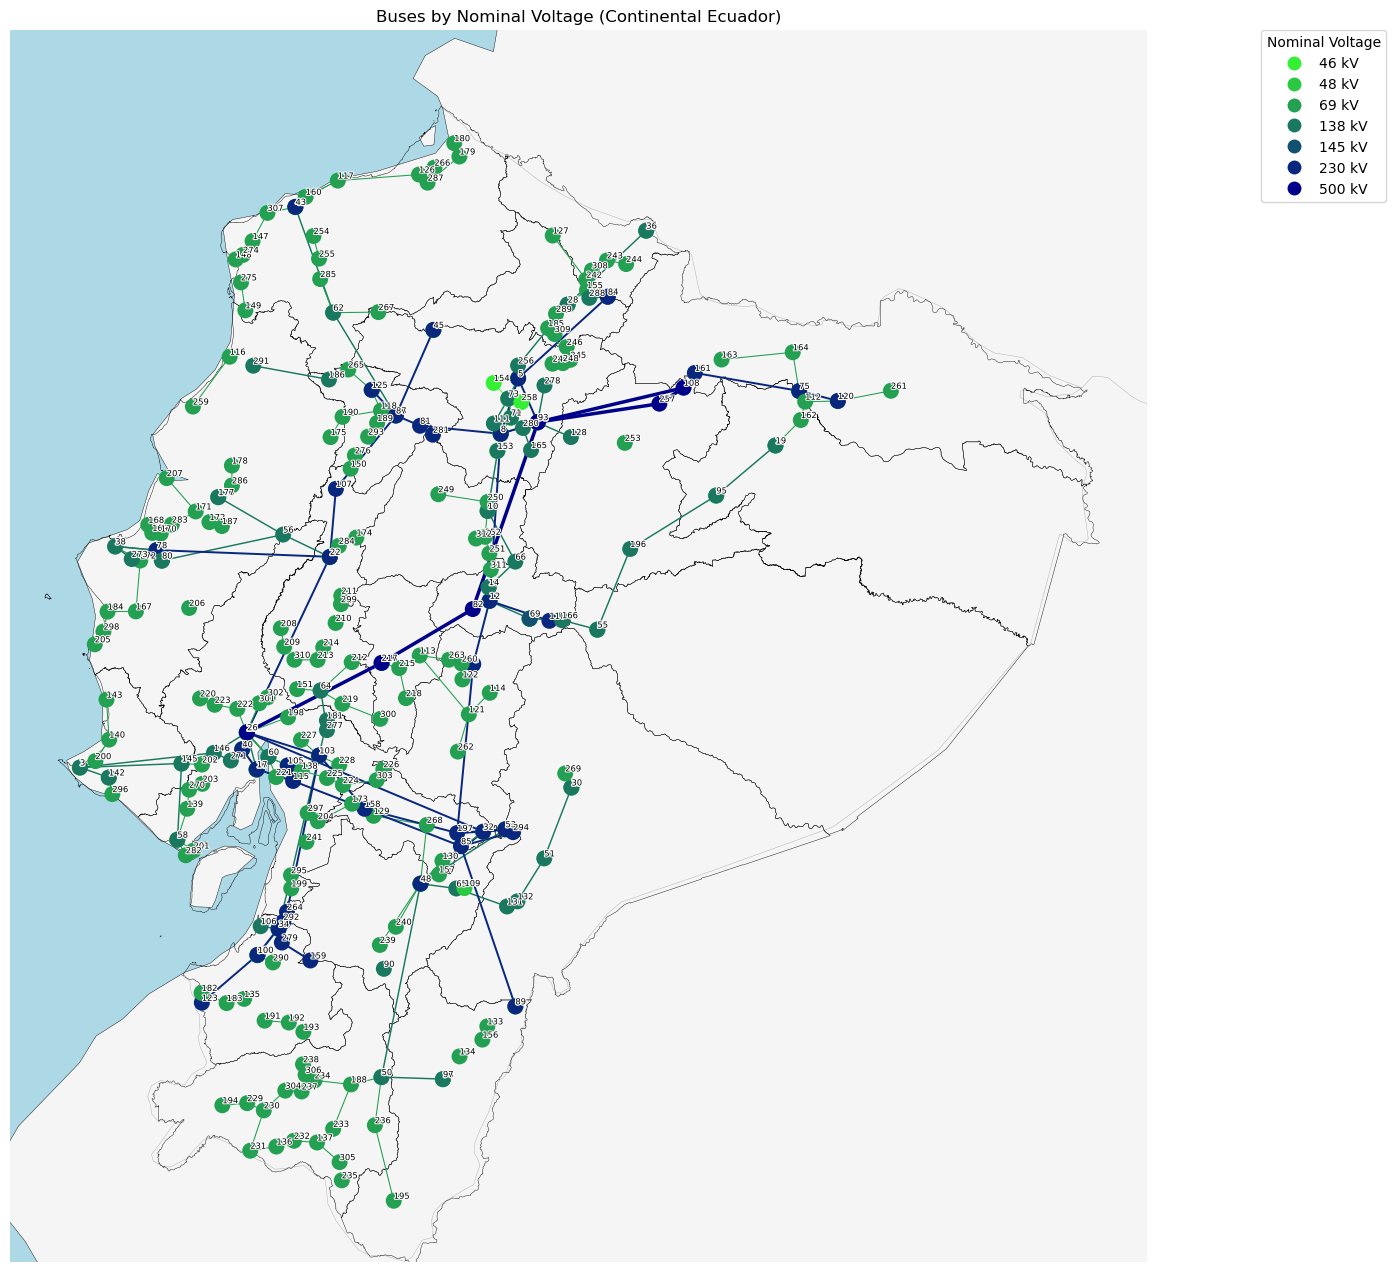

In [113]:


plot_buses_and_lines_by_voltage(network_original, save_name="ecuador_buses_by_voltage_original.png")     

The values of voltage differ from the nominal values from Ecuador

In [114]:
def snap_voltages_to_ecuador_levels(network):
    """
    Snap nominal voltages (v_nom) in a PyPSA network to Ecuador's standard levels.

    Ecuador standard transmission voltages: 500, 230, 138, 69, 48 kV.

    The function modifies the PyPSA network *in place*:
      - network.buses.v_nom
      - network.lines.v_nom

    It adds backup columns 'v_nom_raw' to preserve original values.
    Prints a short summary of all changes.

    Parameters
    ----------
    network : pypsa.Network
        The PyPSA network object to modify.

    Returns
    -------
    network : pypsa.Network
        The same network object (modified in place, returned for chaining).
    """

    import numpy as np
    import pandas as pd

    VALID_VOLTAGES_KV = np.array([500.0, 230.0, 138.0, 69.0, 48.0])

    def _nearest_valid_voltage(values):
        vals = np.asarray(values, dtype=float)
        mask = ~np.isnan(vals)
        snapped = np.full_like(vals, np.nan, dtype=float)
        diffs = np.abs(vals[mask, None] - VALID_VOLTAGES_KV[None, :])
        snapped[mask] = VALID_VOLTAGES_KV[np.argmin(diffs, axis=1)]
        return snapped

    def _apply_snap(df, label):
        if "v_nom" not in df.columns:
            print(f"[WARN] '{label}' has no 'v_nom' column. Skipping.")
            return

        if "v_nom_raw" not in df.columns:
            df["v_nom_raw"] = df["v_nom"].copy()

        before = df["v_nom"].copy()
        df["v_nom"] = _nearest_valid_voltage(df["v_nom"].values)

        changed = before != df["v_nom"]
        n_changed = int(changed.sum())

        if n_changed:
            try: 
                print(f"[{label}] Updated {n_changed} entries in v_nom:")
                summary = (
                    pd.concat([before[changed], df["v_nom"][changed]], axis=1)
                    .rename(columns={0: "old", 1: "new"})
                    .value_counts()
                    .rename("count")
                )
                for (old, new), cnt in summary.items():
                    print(f"  {old:.0f} → {new:.0f} kV : {cnt}")
            except Exception as e:
                print(f"[{label}] Updated {n_changed} entries in v_nom (summary failed: {e})")
        else:
            print(f"[{label}] No changes needed.")

    # --- Apply to main components ---
    _apply_snap(network.buses, "buses")
    _apply_snap(network.lines, "lines")

    # Optional: extend here if needed
    # if hasattr(network, "transformers"):
    #     _apply_snap(network.transformers, "transformers")

    # --- Summary ---
    print("\nFinal voltage levels:")
    print("  buses :", np.sort(network.buses.v_nom.unique()))
    print("  lines :", np.sort(network.lines.v_nom.unique()))

    return network

# Apply voltage snapping
network = snap_voltages_to_ecuador_levels(network)


[buses] Updated 7 entries in v_nom:
[buses] Updated 7 entries in v_nom (summary failed: Grouper for 'v_nom' not 1-dimensional)
[lines] Updated 5 entries in v_nom:
[lines] Updated 5 entries in v_nom (summary failed: Grouper for 'v_nom' not 1-dimensional)

Final voltage levels:
  buses : [ 48.  69. 138. 230. 500.]
  lines : [ 48.  69. 138. 230. 500.]


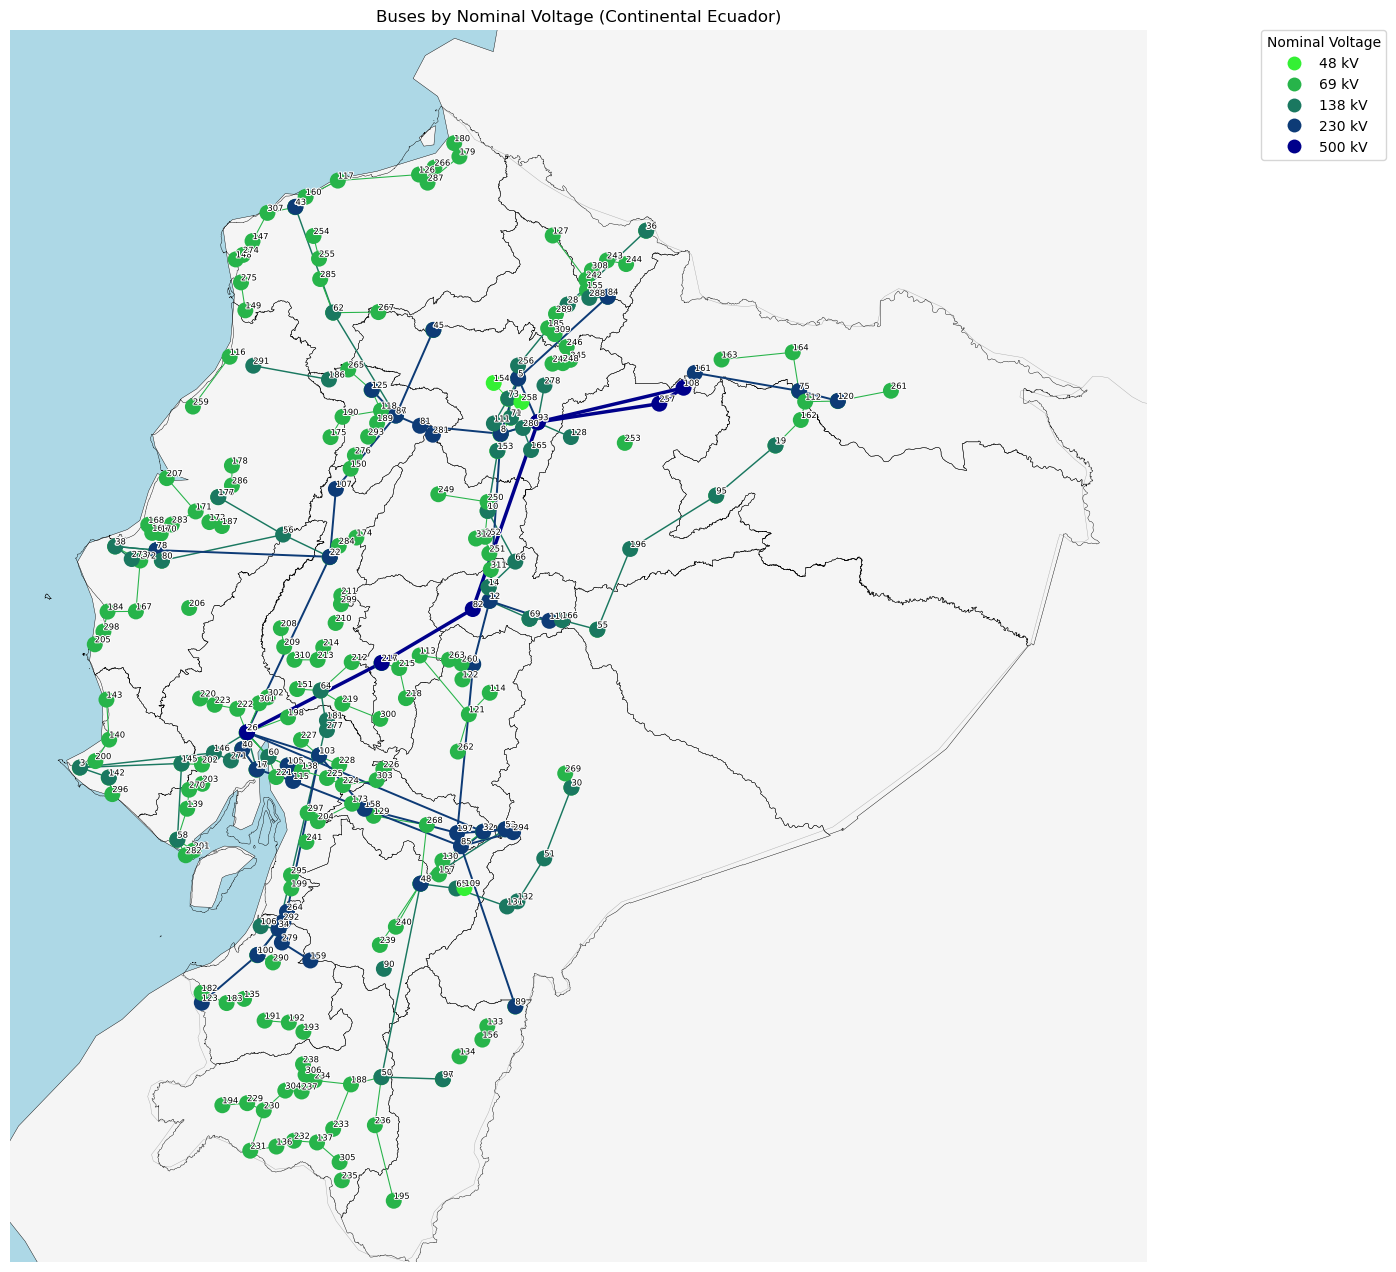

In [115]:
#Plot again to see changes
plot_buses_and_lines_by_voltage(network, save_name="ecuador_buses_by_voltage_snapped.png")   


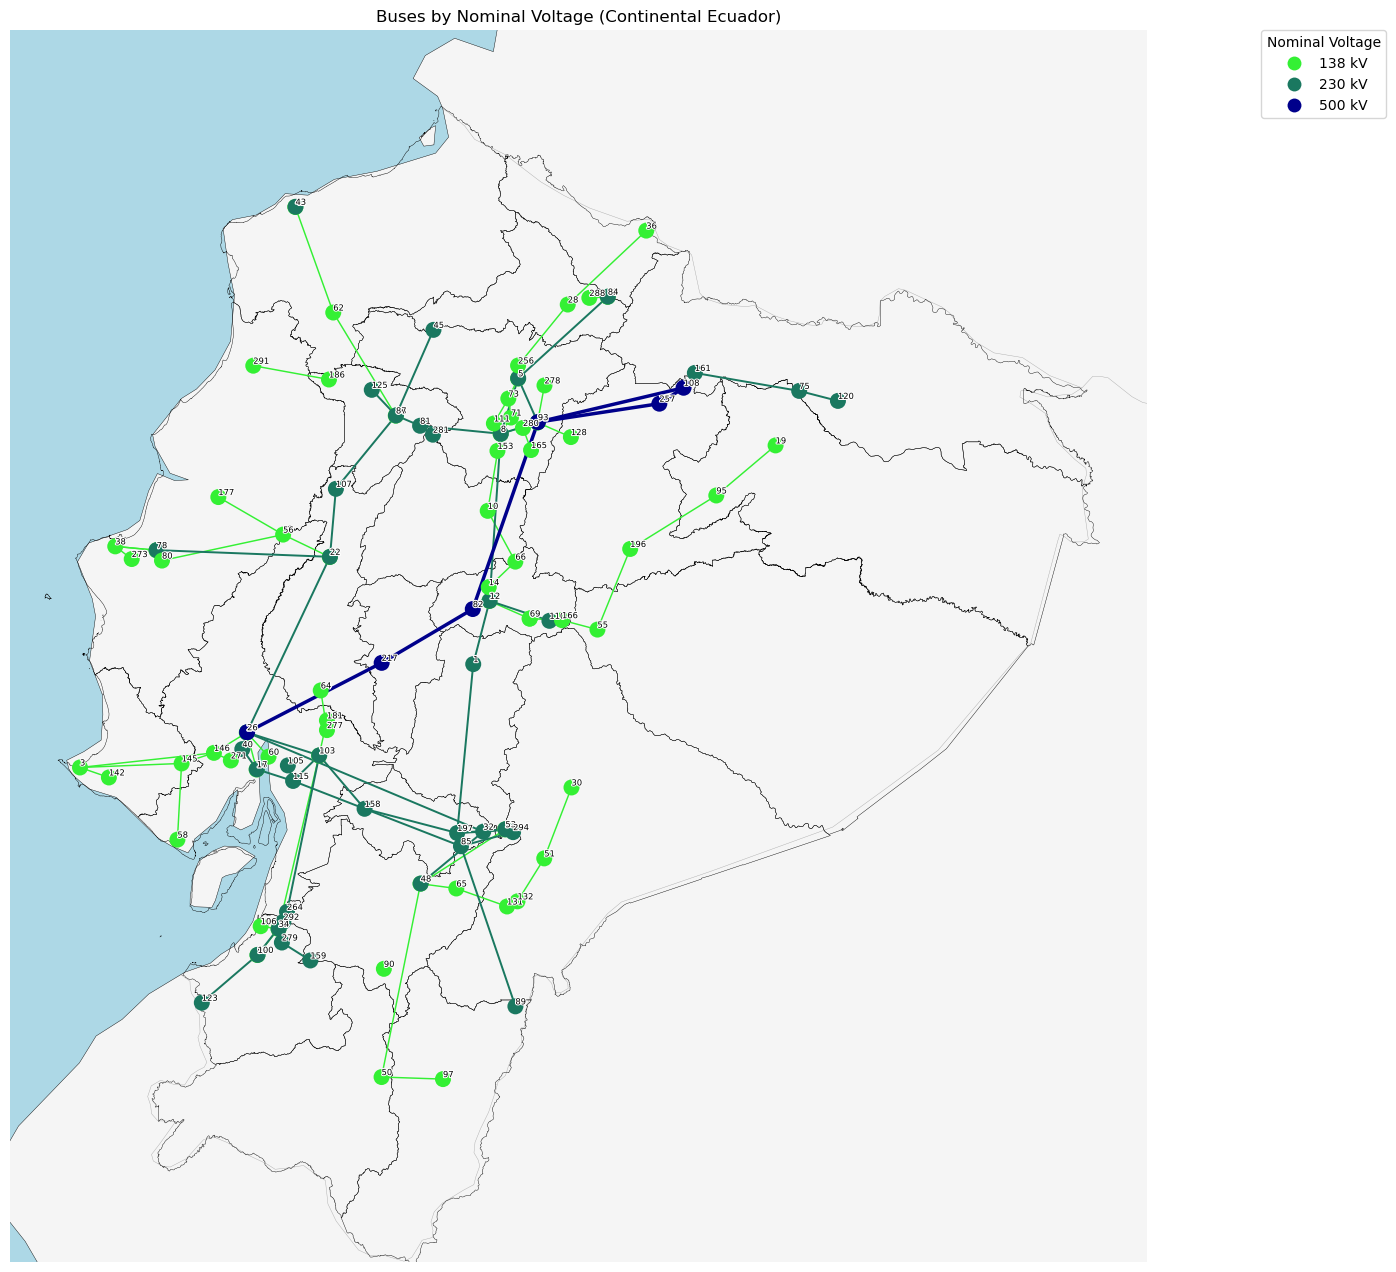

In [116]:
# Visualize only 230 kV and 500 kV buses/lines
buses_500 = network.buses[network.buses.v_nom >= 120] 
lines_500 = network.lines[network.lines.v_nom >= 120] 
network_500 = network.copy()
network_500.buses = buses_500 
network_500.lines = lines_500
plot_buses_and_lines_by_voltage(network_500, save_name="ecuador_buses_HV.png")


The new components from the Master Plan and from the Expansion plans need to be added.
Additionally, appropiate buses for the nuclear option need to be added.

Expansion merged: +23 buses, +16 lines, +15 transformers; updated 0 buses, 0 lines, 0 transformers.


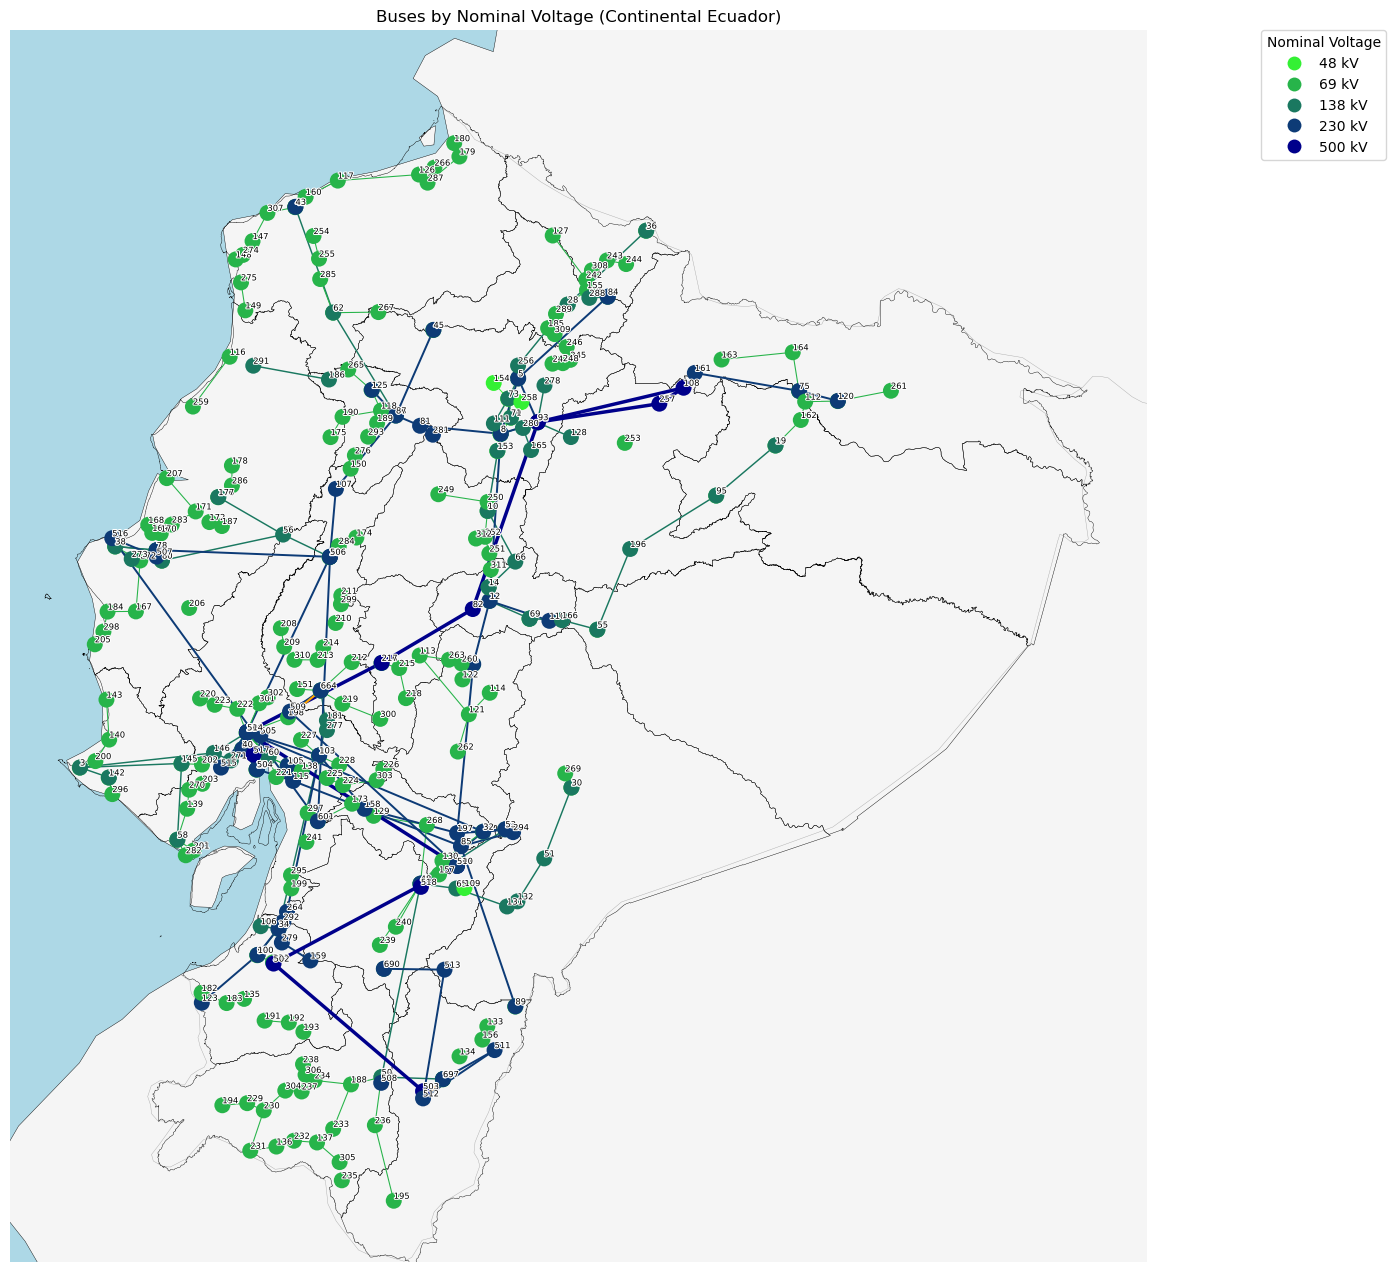

In [117]:
# Copy network and merge expansion data for buses, lines, and transformers using madd

import os
import pandas as pd

# Make a safe copy of the network already loaded as `network`
n_exp = copy.deepcopy(network)

# Base dir for expansion CSVs using your dirs mapping
DATA_DIR = dirs["data/raw/networks"]

# CSV file paths
BUS_EXP_CSV = os.path.join(DATA_DIR, "EC_buses_expansion.csv")
LINE_EXP_CSV = os.path.join(DATA_DIR, "EC_lines_expansion.csv")
TRAFO_EXP_CSV = os.path.join(DATA_DIR, "EC_trafo_expansion.csv")

def _filter_to_allowed_attrs(nw, component, df):
    helper_dict = {
        "Bus": nw.buses,
        "Line": nw.lines,
        "Transformer": nw.transformers,
    }
    allowed = set(helper_dict[component].columns)
    keep_cols = [c for c in df.columns if c in allowed]
    return df[keep_cols]

def _update_existing(nw, component, df):
    table_map = {
        "Bus": "buses",
        "Line": "lines",
        "Transformer": "transformers",
    }
    table = getattr(nw, table_map[component])
    existing = df.index.intersection(table.index)
    if len(existing) > 0:
        cols = df.columns
        table.loc[existing, cols] = df.loc[existing, cols]
    return existing

def _madd_new(nw, component, df):
    if len(df) == 0:
        return
    # df must be indexed by component names and include only valid attrs
    names = df.index
    kwargs = {col: df[col] for col in df.columns}
    nw.madd(component, names, **kwargs)

# 1) Buses expansion
bus_df = pd.read_csv(BUS_EXP_CSV)
if "Name" not in bus_df.columns:
    raise ValueError("EC_buses_expansion.csv must contain a 'Name' column.")
bus_df = bus_df.set_index("Bus")
bus_df = _filter_to_allowed_attrs(n_exp, "Bus", bus_df)

existing_buses = _update_existing(n_exp, "Bus", bus_df)
to_add_buses = bus_df.drop(index=existing_buses, errors="ignore")
_madd_new(n_exp, "Bus", to_add_buses)

# 2) Lines expansion
line_df = pd.read_csv(LINE_EXP_CSV)
if "Line" not in line_df.columns:
    raise ValueError("EC_lines_expansion.csv must contain a 'Line' column.")
line_df = line_df.set_index("ID")
line_df = _filter_to_allowed_attrs(n_exp, "Line", line_df)

existing_lines = _update_existing(n_exp, "Line", line_df)
to_add_lines = line_df.drop(index=existing_lines, errors="ignore")
_madd_new(n_exp, "Line", to_add_lines)


# 3) Transformers expansion
trafo_df = pd.read_csv(TRAFO_EXP_CSV)
if "Transformer" not in trafo_df.columns:
    raise ValueError("EC_trafo_expansion.csv must contain a 'Transformer' column.")
trafo_df = trafo_df.set_index("ID")
trafo_df = _filter_to_allowed_attrs(n_exp, "Transformer", trafo_df)


existing_trafos = _update_existing(n_exp, "Transformer", trafo_df)
to_add_trafos = trafo_df.drop(index=existing_trafos, errors="ignore")
_madd_new(n_exp, "Transformer", to_add_trafos)

# Summary
print(
    f"Expansion merged: +{len(to_add_buses)} buses, "
    f"+{len(to_add_lines)} lines, "
    f"+{len(to_add_trafos)} transformers; "
    f"updated {len(existing_buses)} buses, {len(existing_lines)} lines, {len(existing_trafos)} transformers."
)
plot_buses_and_lines_by_voltage(n_exp, save_name="ecuador_buses_expansion.png")
n_exp.lines.to_csv("ecuador_lines_expanded.csv")

Plot only the expansion

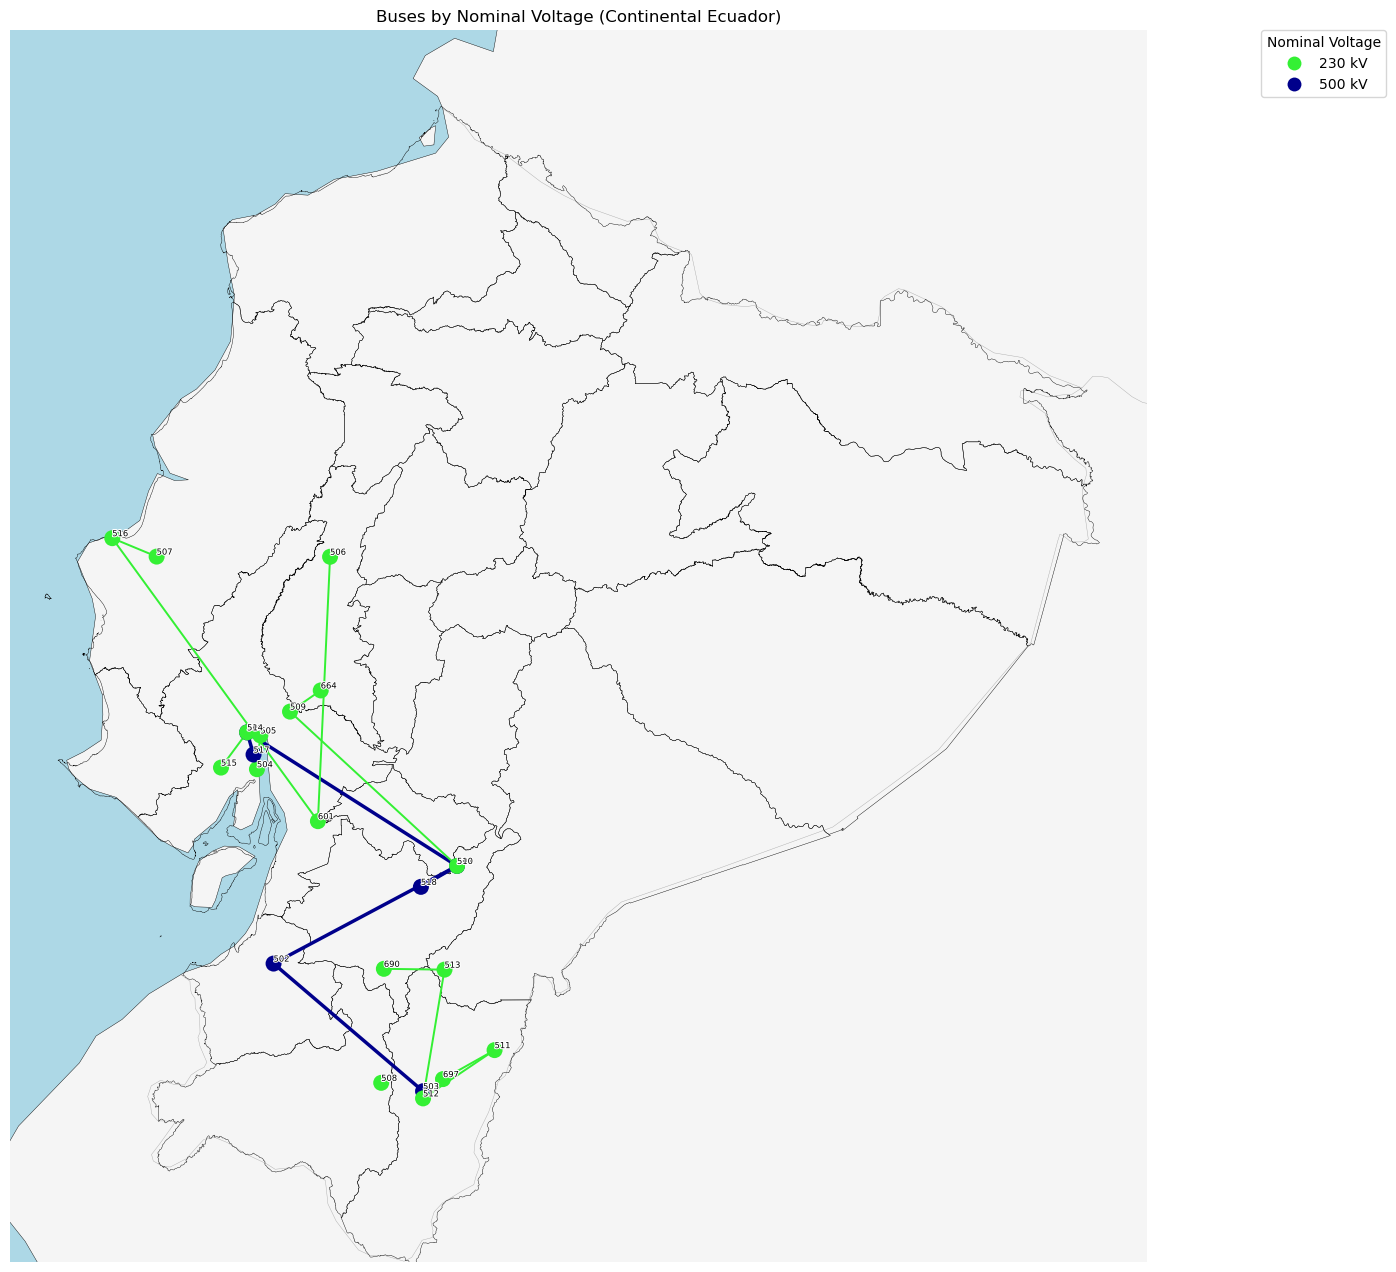

In [118]:
n_only_exp = copy.deepcopy(n_exp)

buses_exp = n_only_exp.buses[n_only_exp.buses.index.astype(str).str.isnumeric() &
                             (n_only_exp.buses.index.astype(int) >= 500)]
lines_exp = n_only_exp.lines[n_only_exp.lines.index.astype(str).str.isnumeric() &
                             (n_only_exp.lines.index.astype(int) >= 500)]
n_only_exp.buses = buses_exp 
n_only_exp.lines = lines_exp


plot_buses_and_lines_by_voltage(n_only_exp, save_name="ecuador_buses_only_expansion.png")

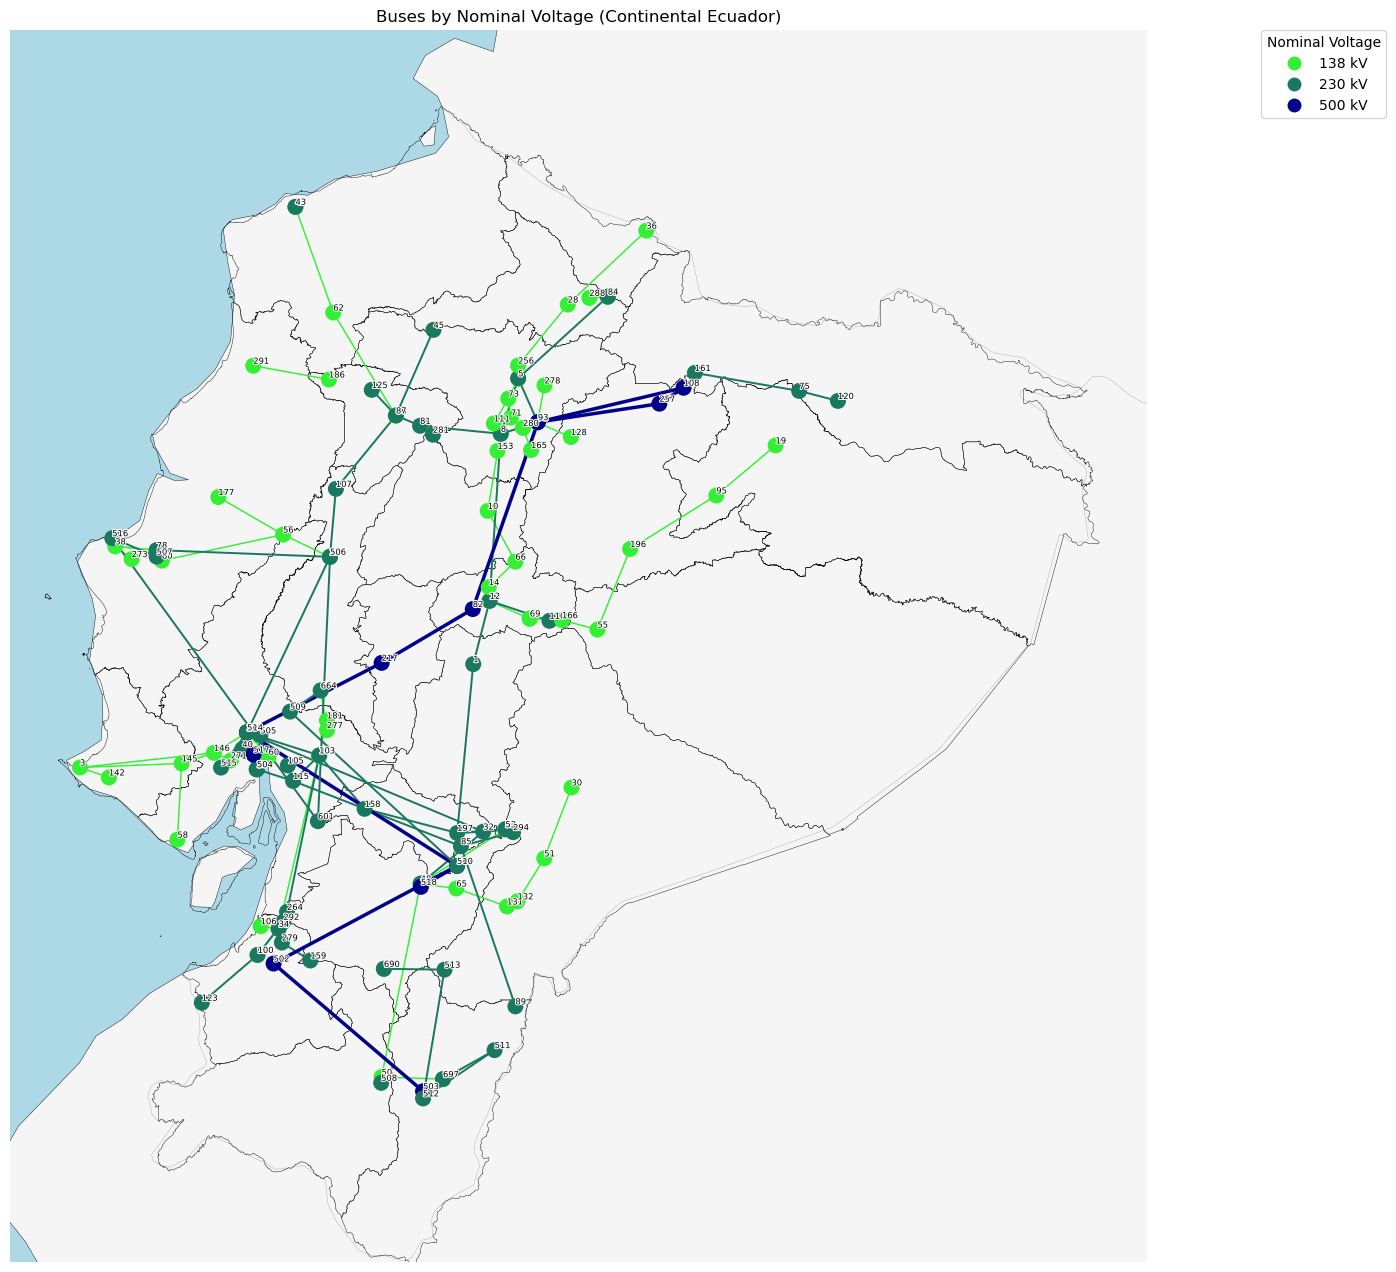

In [119]:
n_only_exp = copy.deepcopy(n_exp)
buses_500 = n_only_exp.buses[n_only_exp.buses.v_nom >= 120] 
lines_500 = n_only_exp.lines[n_only_exp.lines.v_nom >= 120] 
n_only_exp_HV = n_only_exp.copy()
n_only_exp_HV.buses = buses_500 
n_only_exp_HV.lines = lines_500
plot_buses_and_lines_by_voltage(n_only_exp_HV, save_name="ecuador_buses_expanded_HV.png")

n_only_exp_HV.lines.to_csv("ecuador_lines_expanded_HV.csv")
n_only_exp_HV.buses.to_csv("ecuador_buses_expanded_HV.csv")



In [120]:
n_exp.lines.v_nom.unique()


array([230., 138.,  48.,  69., 500.])

In [121]:
# Sanity + topology checks for expansion elements against the existing network

import os
import pandas as pd
import numpy as np
import networkx as nx
from shapely import wkt

# ---- config / paths
DATA_DIR = dirs["data/raw/networks"]
BUS_EXP_CSV  = os.path.join(DATA_DIR, "EC_buses_expansion.csv")
LINE_EXP_CSV = os.path.join(DATA_DIR, "EC_lines_expansion.csv")
TRAFO_EXP_CSV= os.path.join(DATA_DIR, "EC_trafo_expansion.csv")

# Ecuador bounding box (rough, incl. Galápagos if present)
LON_MIN, LON_MAX = -92.0, -74.0
LAT_MIN, LAT_MAX =  -6.0,   3.0

# Non-LV threshold for orphan check (kV)
LV_THRESHOLD = 69.0

# Allowed transformer voltage pairs (rounded to kV)
ALLOWED_TRAFO_PAIRS = {(500,230), (230,138), (230,69), (500,400)}  # extend if needed

issues = []

# ---- Load expansion CSVs (UTF-8 validation and all-empty columns)
def load_csv_utf8(path):
    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError as e:
        issues.append(("utf8_decode_error", f"{os.path.basename(path)}: {e}"))
        raise
    # detect all-empty columns
    empty_cols = [c for c in df.columns if df[c].isna().all()]
    if empty_cols:
        issues.append(("all_empty_columns", {"file": os.path.basename(path), "cols": empty_cols}))
    return df

bus_exp = load_csv_utf8(BUS_EXP_CSV)
line_exp = load_csv_utf8(LINE_EXP_CSV)
trafo_exp = load_csv_utf8(TRAFO_EXP_CSV)

# ---- Build unified buses set: network buses + expansion buses
# From network (prefer lon/lat if present; fall back to x/y)
bus_net = n_exp.buses.copy()
bus_net = bus_net.assign(Bus=bus_net.index)
if "lon" not in bus_net and "x" in bus_net:
    bus_net["lon"] = bus_net["x"]
if "lat" not in bus_net and "y" in bus_net:
    bus_net["lat"] = bus_net["y"]

# From expansion (normalize)
if "Bus" not in bus_exp.columns:
    issues.append(("bus_pk_missing", "Expansion buses CSV missing 'Bus' column"))
# Keep common columns to safely stack
common_bus_cols = bus_net.columns.intersection(bus_exp.columns).tolist()
if "Bus" not in common_bus_cols:
    common_bus_cols.append("Bus")
bus_exp_norm = bus_exp.loc[:, [c for c in common_bus_cols if c in bus_exp.columns]].copy()

buses_all = pd.concat(
    [bus_net.loc[:, common_bus_cols], bus_exp_norm],
    ignore_index=True
).drop_duplicates("Bus", keep="last")

# ---- Schema & PK/FK checks

# PK uniqueness
if buses_all["Bus"].duplicated().any():
    issues.append(("bus_pk_dup", buses_all[buses_all["Bus"].duplicated()]["Bus"].tolist()))

if "Line" in line_exp.columns and line_exp["Line"].duplicated().any():
    issues.append(("line_pk_dup", line_exp[line_exp["Line"].duplicated()]["Line"].tolist()))
if "Transformer" in trafo_exp.columns and trafo_exp["Transformer"].duplicated().any():
    issues.append(("trafo_pk_dup", trafo_exp[trafo_exp["Transformer"].duplicated()]["Transformer"].tolist()))

# FK existence
bus_set = set(buses_all["Bus"])

import numpy as np
import pandas as pd

def to_str_id(s: pd.Series) -> pd.Series:
    def conv(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, np.integer)):
            return str(x)
        if isinstance(x, (float, np.floating)):
            # 204.0 -> "204", 204.5 -> "204.5"
            return str(int(x)) if float(x).is_integer() else str(x)
        # strings: trim whitespace
        return str(x).strip()
    return s.map(conv)

# Normalize bus IDs everywhere
# 1) Buses table (from network+expansion)
buses_all = buses_all.copy()
buses_all["Bus_norm"] = to_str_id(buses_all["Bus"])

# 2) Lines and transformers FK columns
line_exp = line_exp.copy()
trafo_exp = trafo_exp.copy()
for col in ["bus0", "bus1"]:
    if col in line_exp:
        line_exp[col + "_norm"] = to_str_id(line_exp[col])
    if col in trafo_exp:
        trafo_exp[col + "_norm"] = to_str_id(trafo_exp[col])

# Use normalized IDs for FK checks
bus_set = set(buses_all["Bus_norm"].dropna())

def _fk_check_norm(df, kind):
    id_col = "Line" if kind == "line" else "Transformer"
    b0, b1 = "bus0_norm", "bus1_norm"
    if id_col not in df.columns:
        issues.append((f"{kind}_missing_id_col", f"Missing '{id_col}'"))
        return
    for side in [b0, b1]:
        if side not in df.columns:
            issues.append((f"{kind}_missing_fk_col", f"Missing '{side}'; normalize earlier"))
            return
    miss0 = df.loc[~df[b0].isin(bus_set), [id_col, b0]]
    miss1 = df.loc[~df[b1].isin(bus_set), [id_col, b1]]
    if not miss0.empty:
        issues.append((f"{kind}_missing_bus0", miss0))
    if not miss1.empty:
        issues.append((f"{kind}_missing_bus1", miss1))

_fk_check_norm(line_exp, "line")
_fk_check_norm(trafo_exp, "trafo")


# Coords sanity on buses
if {"lon","lat"}.issubset(buses_all.columns):
    bad_coords = buses_all[(buses_all["lon"] < LON_MIN) | (buses_all["lon"] > LON_MAX) |
                           (buses_all["lat"] < LAT_MIN) | (buses_all["lat"] > LAT_MAX)]
    if not bad_coords.empty:
        issues.append(("bad_coords", bad_coords[["Bus","lon","lat"]]))

# Voltage sanity
# Build bus->v_nom map (rounded to integer kV for comparisons)
if "v_nom" in buses_all.columns:
    bmap = buses_all.set_index("Bus")["v_nom"]
    bmap_r = bmap.round(0)

    # Lines: v_nom(line) equals both buses
    if {"bus0","bus1","v_nom"}.issubset(line_exp.columns):
        v0 = bmap_r.reindex(line_exp["bus0"]).values
        v1 = bmap_r.reindex(line_exp["bus1"]).values
        lv = line_exp["v_nom"].round(0).values
        ln_bad_v = line_exp[(v0 != lv) | (v1 != lv)]
        if not ln_bad_v.empty:
            issues.append(("line_vnom_mismatch", ln_bad_v[["Line","v_nom","bus0","bus1"]]
                           if "Line" in ln_bad_v.columns else ln_bad_v[["v_nom","bus0","bus1"]]))

    # Transformers: different voltage levels and in allowed pairs (optional)
    if {"bus0","bus1"}.issubset(trafo_exp.columns):
        t_v0 = bmap_r.reindex(trafo_exp["bus0"]).values
        t_v1 = bmap_r.reindex(trafo_exp["bus1"]).values
        same = np.isfinite(t_v0) & np.isfinite(t_v1) & (t_v0 == t_v1)
        tr_same = trafo_exp[same]
        if not tr_same.empty:
            issues.append(("trafo_same_voltage", tr_same[["Transformer","bus0","bus1"]]
                           if "Transformer" in tr_same.columns else tr_same[["bus0","bus1"]]))

        # Check allowed pairs (ignore NaNs)
        pairs = pd.DataFrame({"v0": t_v0, "v1": t_v1}, index=trafo_exp.index).dropna()
        bad_pairs_mask = ~pairs.apply(lambda s: (int(s["v0"]), int(s["v1"])) in ALLOWED_TRAFO_PAIRS
                                                 or (int(s["v1"]), int(s["v0"])) in ALLOWED_TRAFO_PAIRS, axis=1)
        bad_pairs = trafo_exp.loc[pairs.index[bad_pairs_mask]]
        if not bad_pairs.empty:
            issues.append(("trafo_unexpected_voltage_pair",
                           bad_pairs[["Transformer","bus0","bus1"]]
                           if "Transformer" in bad_pairs.columns else bad_pairs[["bus0","bus1"]]))

# Ratings sanity (lines)
for req in ["num_parallel","s_nom","s_max_pu"]:
    if req not in line_exp.columns:
        issues.append(("line_missing_rating_col", f"Missing '{req}'"))
ln_bad_rating = line_exp[
    (line_exp.get("num_parallel", 1) < 1) |
    (line_exp.get("s_nom", 0) < 0) |
    (line_exp.get("s_max_pu", 1.0) <= 0) |
    (line_exp.get("s_max_pu", 1.0) > 1.2)
]
if not ln_bad_rating.empty:
    issues.append(("line_rating_sanity", ln_bad_rating[["Line","num_parallel","s_nom","s_max_pu"]]
                   if {"Line","num_parallel","s_nom","s_max_pu"}.issubset(ln_bad_rating.columns)
                   else ln_bad_rating))

# Geometry sanity (lines)
def geom_ok(s):
    try:
        g = wkt.loads(s)
        if g.is_empty:
            return False
        if g.geom_type == "MultiLineString":
            # at least one segment with >=2 points
            return any(len(seg.coords) >= 2 for seg in g.geoms)
        if g.geom_type == "LineString":
            return len(g.coords) >= 2
        return False
    except Exception:
        return False

if "geometry" in line_exp.columns:
    ln_bad_geom = line_exp[~line_exp["geometry"].apply(geom_ok)]
    if not ln_bad_geom.empty:
        issues.append(("line_geom_invalid", ln_bad_geom[["Line","geometry"]].head(20)
                       if {"Line","geometry"}.issubset(ln_bad_geom.columns) else ln_bad_geom.head(20)))

# Length sanity (lines)
if "length" in line_exp.columns:
    ln_bad_len = line_exp[(line_exp["length"] <= 0) | (line_exp["length"] > 600_000)]  # meters if provided that way
    if ln_bad_len.empty and line_exp["length"].max() < 2000:  # if units are km, switch bounds
        ln_bad_len = line_exp[(line_exp["length"] <= 0) | (line_exp["length"] > 600)]
    if not ln_bad_len.empty:
        issues.append(("line_length_bounds", ln_bad_len[["Line","length"]]
                       if {"Line","length"}.issubset(ln_bad_len.columns) else ln_bad_len))

# ---- Topology & connectivity
# Orphan buses by lines/transformers only (ignore generators)

import pandas as pd
import numpy as np
from collections import defaultdict

def to_str_id(s: pd.Series) -> pd.Series:
    def conv(x):
        if pd.isna(x): return np.nan
        if isinstance(x, (int, np.integer)): return str(x)
        if isinstance(x, (float, np.floating)):
            return str(int(x)) if float(x).is_integer() else str(x)
        return str(x).strip()
    return s.map(conv)

# 1) Normalize bus IDs in unified buses and expansion FKs
buses_all = buses_all.copy()
buses_all["Bus_norm"] = to_str_id(buses_all["Bus"])

line_exp = n_exp.lines.copy()
trafo_exp = n_exp.transformers.copy()
for col in ["bus0", "bus1"]:
    if col in line_exp.columns:
        line_exp[col + "_norm"] = to_str_id(line_exp[col])
    if col in trafo_exp.columns:
        trafo_exp[col + "_norm"] = to_str_id(trafo_exp[col])

# 2) Degree tally from lines and transformers (generators excluded)
deg = defaultdict(int)
for b in buses_all["Bus_norm"]:
    deg[b] = 0

if {"bus0_norm","bus1_norm"}.issubset(line_exp.columns):
    for b0, b1 in line_exp[["bus0_norm","bus1_norm"]].itertuples(index=False, name=None):
        if pd.notna(b0): deg[b0] += 1
        if pd.notna(b1): deg[b1] += 1

if {"bus0_norm","bus1_norm"}.issubset(trafo_exp.columns):
    for b0, b1 in trafo_exp[["bus0_norm","bus1_norm"]].itertuples(index=False, name=None):
        if pd.notna(b0): deg[b0] += 1
        if pd.notna(b1): deg[b1] += 1

# 3) Orphans: zero degree w.r.t. lines/transformers
orphans_norm = [b for b, d in deg.items() if d == 0]

if orphans_norm:
    orphan_rows = buses_all[buses_all["Bus_norm"].isin(orphans_norm)]
    cols = ["Bus","v_nom","lon","lat"] if {"lon","lat"}.issubset(orphan_rows.columns) else ["Bus","v_nom"]
    issues.append(("orphan_buses_lines_trafos_only", orphan_rows[cols]))

# Voltage-layer graphs
def build_graph(df_lines, v_target):
    if not {"bus0","bus1","v_nom"}.issubset(df_lines.columns):
        return nx.Graph()
    dfv = df_lines[np.isclose(df_lines["v_nom"].round(0), v_target)]
    G = nx.Graph()
    # nodes: buses at that voltage
    G.add_nodes_from(buses_all.loc[np.isclose(buses_all["v_nom"].round(0), v_target), "Bus"].tolist())
    # edges: line pairs
    G.add_edges_from(dfv[["bus0","bus1"]].itertuples(index=False, name=None))
    return G

voltages_to_check = []
if "v_nom" in line_exp.columns:
    voltages_to_check = sorted(pd.unique(line_exp["v_nom"].round(0).dropna()))
topo_report = {}
for v in voltages_to_check:
    Gv = build_graph(line_exp, v)
    comps = list(nx.connected_components(Gv))
    topo_report[f"{int(v)}kV"] = {
        "n_components": len(comps),
        "sizes": sorted([len(c) for c in comps], reverse=True)[:5]
    }

# Degree checks at known junctions (optional, only if present)
def degree_at(bus_id, df_lines):
    if not {"bus0","bus1"}.issubset(df_lines.columns):
        return 0
    return (df_lines["bus0"].eq(bus_id) | df_lines["bus1"].eq(bus_id)).sum()

# Example: Taday 500/230 (if present)
deg_expect_violations = []
for bus_id, min_deg in [(501, 2), (510, 1)]:  # 501: Taday500, 510: Taday230 from your CSVs
    if bus_id in bus_set:
        d = degree_at(bus_id, line_exp)
        if d < min_deg:
            deg_expect_violations.append((bus_id, d, min_deg))
if deg_expect_violations:
    issues.append(("degree_expectations", pd.DataFrame(deg_expect_violations, columns=["bus","degree","min_expected"])))

# Transformer bridges with unique bus->voltage map and robust dtype handling

import numpy as np
import pandas as pd

# 1) Build a unique bus->v_nom map (rounded to kV)
# Strategy: keep last occurrence (expansion can override), then index by Bus_norm
if "Bus_norm" not in buses_all.columns or "v_nom" not in buses_all.columns:
    issues.append(("missing_bus_norm_or_vnom", "buses_all must contain Bus_norm and v_nom"))
else:
    bus_v = (
        buses_all
        .dropna(subset=["Bus_norm"])               # ensure key exists
        .drop_duplicates("Bus_norm", keep="last")  # ensure unique keys
        .set_index("Bus_norm")["v_nom"]
        .round(0)
    )

    # 2) Use existing normalized FKs in trafo_exp and map to voltages
    if {"bus0_norm","bus1_norm"}.issubset(trafo_exp.columns):
        v0_s = trafo_exp["bus0_norm"].map(bus_v)
        v1_s = trafo_exp["bus1_norm"].map(bus_v)

        # 3) Keep rows where both voltages exist and are different (positional compare)
        mask_diff = (~v0_s.isna()).to_numpy() & (~v1_s.isna()).to_numpy() & (v0_s.to_numpy() != v1_s.to_numpy())

        # 4) Found bridge pairs (rounded ints)
        pairs_arr = np.column_stack((v0_s.to_numpy()[mask_diff], v1_s.to_numpy()[mask_diff]))
        pairs_arr = np.round(pairs_arr, 0).astype(int, copy=False)
        bridge_pairs_found = set(tuple(sorted((a, b))) for a, b in pairs_arr)

        # 5) Required bridges for your levels [48, 69, 138, 230, 500]
        REQUIRED = {(48, 138), (69, 138), (69, 230), (69, 500), (138, 230), (230, 500)}  # add (69, 48) or (230, 69) if policy requires

        missing = [p for p in REQUIRED if p not in bridge_pairs_found]
        if missing:
            issues.append(("missing_transformer_bridges", {
                "required": sorted(REQUIRED),
                "found": sorted(bridge_pairs_found),
                "missing": sorted(missing),
            }))
    else:
        issues.append(("trafo_norm_fk_missing", "trafo_exp must contain bus0_norm and bus1_norm"))




# ---- Output
print("TOPO SUMMARY:", topo_report)
print("ISSUES FOUND:", [k for k,_ in issues])
#To inspect details inline in a notebook:
for k, d in issues:
    if k != 'all_empty_columns':
        display(k, d)  




TOPO SUMMARY: {'48kV': {'n_components': 4, 'sizes': [3, 2, 1, 1]}, '69kV': {'n_components': 66, 'sizes': [17, 17, 11, 9, 8]}, '138kV': {'n_components': 12, 'sizes': [22, 9, 9, 7, 5]}, '230kV': {'n_components': 29, 'sizes': [30, 5, 4, 3, 3]}, '500kV': {'n_components': 8, 'sizes': [6, 6, 1, 1, 1]}}
ISSUES FOUND: ['all_empty_columns', 'all_empty_columns', 'all_empty_columns', 'orphan_buses_lines_trafos_only']


'orphan_buses_lines_trafos_only'

,Bus,v_nom,lon,lat
109,109,48.0,-78.7385,-2.9038
122,122,69.0,-78.7498,-1.7366
134,134,69.0,-78.7659,-3.8451
135,135,69.0,-79.9708,-3.5235
168,168,69.0,-80.5068,-0.8724
172,172,69.0,-80.1647,-0.8570
180,180,69.0,-78.7958,1.2621
187,187,69.0,-80.0950,-0.8791
193,193,69.0,-79.6392,-3.7076
203,203,69.0,-80.2042,-2.3207


In [122]:
# Drop the orphan  buses 

orphans = None
for issue_key, data in issues:
    if issue_key == "orphan_buses_lines_trafos_only":
        orphans = data
        break   

orphans_ids = orphans['Bus'].tolist() if orphans is not None else []
orphans_ids= pd.Index(orphans_ids)

In [ ]:
import pandas as pd
import numpy as np

def buses_referenced_by_components(n):
    refs = set()
    for comp, df in [
        ("loads", n.loads),
        ("generators", n.generators),
        ("storage_units", n.storage_units),
        ("stores", n.stores),
        ("links", n.links),
        ("lines", n.lines),
        ("transformers", n.transformers),
        ("shunt_impedances", n.shunt_impedances),
    ]:
        if df.empty: 
            continue
        for col in [c for c in df.columns if c.startswith("bus")]:
            refs |= set(df[col].dropna().astype(str))
    return refs

ref_buses = buses_referenced_by_components(n_exp)
bus_index_str = n_exp.buses.index.astype(str)
true_orphans_idx = n_exp.buses.loc[~bus_index_str.isin(ref_buses)].index

# If you already have a candidate list (like your table), intersect:
candidate_orphans = orphans_ids
true_orphans_idx = candidate_orphans.intersection(true_orphans_idx)
true_orphans_idx

n_epx


Index(['109', '122', '134', '135', '168', '172', '180', '187', '193', '203',
       '206', '210', '226', '235', '238', '241', '253'],
      dtype='object')

KeyError: 517

In [124]:
# Make a copy for evaluation
n_exp_clean = n_exp.copy()

# Drop only if truly unreferenced
for b in true_orphans_idx:
    n_exp_clean.remove("Bus", b)

# Optional: log what you removed
pd.DataFrame({"removed_bus": true_orphans_idx}).to_csv("removed_orphan_buses.csv", index=False)

#assert that all the buses have been removed
for b in true_orphans_idx:
    assert b not in n_exp_clean.buses.index, f"Bus {b} was not removed properly."


Now, we need three network objects
1) One containing only the original network structure, that is, no buses, trafos, or lines that represent the expansion
2) One that contians the network structure as per the master plan
3) One that contians the nuclear buses 

The final network is the one already containing the nuclear option, so we remove from there




In [ ]:
network_nuclear = copy.deepcopy(n_exp_clean)


KeyError: 517

In [ ]:
network_prod_mix = copy.deepcopy(network_nuclear)
# 1) Nuclear bus IDs (as INTs), robust to NaNs/whitespace
mask_nuc = bus_exp["Name"].astype(str).str.strip().str.lower().str.contains("nuclear", na=False)
ids_bus_nuclear = bus_exp.loc[mask_nuc, "Bus"].astype(int).tolist()
print("nuclear buses:", ids_bus_nuclear)

# 2) Make sure you didn't accidentally empty lines_exp by indexing on the *index*.
#    If you had something like lines_exp = n_only_exp.lines[n_only_exp.lines.index >= 500]
#    that's wrong for string IDs. Use the full table or a column-based filter.
lines_exp = n_exp.lines.copy()          # <-- reset to full lines
trafo_exp = n_exp.transformers.copy()   # <-- full transformers

# 3) Align dtypes for membership tests
for df in (lines_exp, trafo_exp):
    for col in ("bus0", "bus1"):
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

ids_bus_nuclear_int = pd.Series(ids_bus_nuclear, dtype="Int64")

# 4) Filter lines and transformers
ids_lines_nuclear = lines_exp[
    lines_exp["bus0"].isin(ids_bus_nuclear_int) |
    lines_exp["bus1"].isin(ids_bus_nuclear_int)
].index.to_list()
ids_lines_nuclear_int = pd.Series(ids_lines_nuclear, dtype="Int64")

ids_trafo_nuclear = trafo_exp[
    trafo_exp["bus0"].isin(ids_bus_nuclear_int) |
    trafo_exp["bus1"].isin(ids_bus_nuclear_int)
].index.to_list()
ids_trafo_nuclear_int = pd.Series(ids_trafo_nuclear, dtype="Int64")

print("lines hitting nuclear buses:", ids_lines_nuclear)
print("trafos hitting nuclear buses:",ids_trafo_nuclear)


nuclear buses: [517, 518]
lines hitting nuclear buses: ['504', '505']
trafos hitting nuclear buses: ['513', '514']


KeyError: 517

In [ ]:


#remove the buses, trafos, and lines from the nuclear network

for b in ids_bus_nuclear_int.to_list():
    print(b)
    network_prod_mix.remove("Bus", b)
for l in ids_lines_nuclear_int.to_list():
    network_prod_mix.remove("Line", l)

for t in ids_trafo_nuclear_int.to_list():
    network_prod_mix.remove("Transformer", t)



517


KeyError: '[517] not found in axis'